## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [181]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

In [182]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [183]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [184]:
# Opening JSON file 
f = open('/kaggle/input/automatic-ticket-classification/complaints-2021-05-14_08_16.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [185]:
# Inspect the dataframe to understand the given data.
df.sample(10)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
51455,complaint-public-v2,complaint,264094,0.0,None,90033,264094,Credit decision / Underwriting,2013-01-25T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Postal mail,2013-01-25T12:00:00-05:00,None,Other mortgage,Yes,,None,N/A
1349,complaint-public-v2,complaint,537731,0.0,None,622XX,537731,Repaying your loan,2013-09-20T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2013-09-23T12:00:00-05:00,None,Non-federal student loan,Yes,,None,N/A
478,complaint-public-v2,complaint,3411831,0.0,None,606XX,3411831,Problem with a credit reporting company's inve...,2019-10-20T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-10-21T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On XX/XX/2019, I applied for Chase Freedom Unl...",Was not notified of investigation status or re...,Consent provided
51161,complaint-public-v2,complaint,1770041,0.0,None,94131,1770041,"Loan modification,collection,foreclosure",2016-02-02T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2016-02-04T12:00:00-05:00,None,Other mortgage,Yes,,None,N/A
69267,complaint-public-v2,complaint,2134597,0.0,None,77073,2134597,"Loan modification,collection,foreclosure",2016-09-27T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2016-10-04T12:00:00-05:00,None,Other mortgage,Yes,,None,N/A
4926,complaint-public-v2,complaint,3512257,0.0,None,20874,3512257,Problem with a purchase shown on your statement,2020-01-27T12:00:00-05:00,MD,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2020-01-28T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Card was charged for something you did not pur...,N/A
34701,complaint-public-v2,complaint,3755952,0.0,None,917XX,3755952,Managing an account,2020-07-21T12:00:00-05:00,CA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2020-07-21T12:00:00-05:00,None,Checking account,Yes,I bought a product for {$110.00} at XXXX XXXX ...,Deposits and withdrawals,Consent provided
27624,complaint-public-v2,complaint,127346,0.0,None,841XX,127346,"Loan modification,collection,foreclosure",2012-07-31T12:00:00-05:00,UT,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2012-08-01T12:00:00-05:00,None,Conventional adjustable mortgage (ARM),Yes,,None,N/A
55152,complaint-public-v2,complaint,980309,0.0,None,83814,980309,Can't repay my loan,2014-08-12T12:00:00-05:00,ID,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2014-08-12T12:00:00-05:00,None,Non-federal student loan,Yes,,Can't get flexible payment options,N/A
52109,complaint-public-v2,complaint,1504443,0.0,None,75070,1504443,Other transaction issues,2015-08-05T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2015-08-05T12:00:00-05:00,None,International money transfer,Yes,,None,Consent not provided


In [186]:
df.shape

(78313, 22)

In [187]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [188]:
#Assign new column names
for column_name in df.columns:
    cleaned_column_name = re.sub('^_', '', column_name)
    cleaned_column_name = re.sub('^source\.', '', cleaned_column_name)
    df.rename(columns={column_name: cleaned_column_name}, inplace=True)

In [189]:
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [190]:
df.sample(10)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
8916,complaint-public-v2,complaint,2851186,0.0,None,None,2851186,Incorrect information on your report,2018-03-22T12:00:00-05:00,MS,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-03-22T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, I called in my mortgage payment...",Account status incorrect,Consent provided
34444,complaint-public-v2,complaint,4171015,0.0,None,60619,4171015,Incorrect information on your report,2021-02-27T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2021-02-27T12:00:00-05:00,None,Credit reporting,Yes,,Information belongs to someone else,Consent not provided
53799,complaint-public-v2,complaint,1840631,0.0,None,325XX,1840631,"Loan servicing, payments, escrow account",2016-03-19T12:00:00-05:00,FL,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2016-03-19T12:00:00-05:00,None,FHA mortgage,Yes,JP Morgan Chase keeps charging us for Inspecti...,None,Consent provided
2142,complaint-public-v2,complaint,189840,0.0,None,10453,189840,"Account opening, closing, or management",2012-11-13T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2012-11-14T12:00:00-05:00,None,Savings account,Yes,,None,N/A
66842,complaint-public-v2,complaint,374514,0.0,None,None,374514,Problems caused by my funds being low,2013-04-04T12:00:00-05:00,None,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2013-04-05T12:00:00-05:00,None,Checking account,Yes,,None,N/A
6137,complaint-public-v2,complaint,3605035,0.0,None,91302,3605035,Trouble using your card,2020-04-10T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2020-04-13T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Credit card company won't increase or decrease...,N/A
38177,complaint-public-v2,complaint,1190916,0.0,None,067XX,1190916,Other fee,2015-01-12T12:00:00-05:00,CT,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2015-01-12T12:00:00-05:00,None,None,Yes,,None,N/A
20708,complaint-public-v2,complaint,4207798,0.0,None,704XX,4207798,Closing an account,2021-03-10T12:00:00-05:00,LA,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2021-03-12T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
118,complaint-public-v2,complaint,3186854,0.0,None,21409,3186854,Attempts to collect debt not owed,2019-03-21T12:00:00-05:00,MD,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-21T12:00:00-05:00,None,Credit card debt,Yes,,Debt was result of identity theft,Consent not provided
24377,complaint-public-v2,complaint,3556323,0.0,None,029XX,3556323,Problem with a lender or other company chargin...,2020-03-06T12:00:00-05:00,RI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2020-03-06T12:00:00-05:00,None,Checking account,Yes,"Identity theft. In XX/XX/2020, I received mult...",Transaction was not authorized,Consent provided


In [191]:
(df.complaint_what_happened == "").sum()

57241

In [192]:
#Assign nan in place of blanks in the complaints column
df[df.complaint_what_happened == ""] = np.nan 

In [193]:
(df.complaint_what_happened == "").sum()

0

In [194]:
(df.complaint_what_happened == np.nan).sum()

0

In [195]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

In [196]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [197]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    # Make the text lowercase
    text = text.lower()
    
    # Remove text in square brackets using regular expression
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove punctuation using string library
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove words containing numbers using regular expression
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [198]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
    # Tokenize the text into words
    words = word_tokenize(text.lower())
    
    # Initialize the WordNet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize each word using its part of speech (POS)
    lemmatized_words = []
    for word, pos in nltk.pos_tag(words):
        pos_letter = pos[0].lower() if pos[0].lower() in ['a', 'r', 'n', 'v'] else None
        
        if pos_letter == None:
            lemmatized_words.append(word)
        else:
            lemma = lemmatizer.lemmatize(word, pos=pos_letter)
            lemmatized_words.append(lemma)
    
    # Join the lemmatized words back into a sentence
    lemmatized_text = ' '.join(lemmatized_words)
    
    return lemmatized_text

In [199]:
df['cleaned_complaints'] = df['complaint_what_happened'].apply(clean_text)

In [200]:
from tqdm import tqdm
tqdm.pandas()
df['lemmatized_complaints'] = df['cleaned_complaints'].progress_apply(lemmatize_text)

100%|██████████| 21072/21072 [07:05<00:00, 49.51it/s]


In [201]:
df['lemmatized_complaints'].sample(10)

54631    dear sir or madam my name be xxxx xxxx xxxx an...
28680    chase bank fraud department contact me claim u...
20413    re xxxx i have upload copy of credit report fr...
62372    i begin this process a year ago i apply for mo...
55553    payment make on xxxxxxxx on chase credit card ...
39968    chase account end in xxxx xxxx fax this accoun...
20370    xxxx xxxx i recently apply for the freedom xxx...
61572    on at approximately xxxx i attempt to deposit ...
47635    i submit for mortgage assistance in xxxx of xx...
58110    i receive a letter from chase ask me to verify...
Name: lemmatized_complaints, dtype: object

In [202]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame(columns=['complaint_what_happened','lemmatized_complaints'], data=df[['complaint_what_happened','lemmatized_complaints']])

In [203]:
df_clean

,complaint_what_happened,lemmatized_complaints
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and i apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade my xxxx xxxx card in and be tell by ...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket i come...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...
...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i call chas my xxxx xxxx...
78310,I am not familiar with XXXX pay and did not un...,i be not familiar with xxxx pay and do not und...
78311,I have had flawless credit for 30 yrs. I've ha...,i have have flawless credit for yrs ive have c...


In [204]:
# Write your function to extract the POS tags
def extract_pos_tag(sentence):
    # Tokenize the sentence into words
    words = word_tokenize(sentence)
    
    # Perform POS tagging using nltk.pos_tag
    pos_tags = nltk.pos_tag(words)
    
    # Extract words with tags 'NN', join them, and return
    return ' '.join([word for (word, tag) in pos_tags if tag == "NN"])


In [205]:
df_clean["complaint_POS_removed"] = df_clean["lemmatized_complaints"].progress_apply(extract_pos_tag)
df_clean["length"] = df_clean["complaint_POS_removed"].progress_apply(len)

100%|██████████| 21072/21072 [00:00<00:00, 373823.63it/s]


In [206]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,length
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and i apprec...,morning name stop bank cardmember service ask ...,157
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade my xxxx xxxx card in and be tell by ...,i card agent upgrade date agent information or...,107
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,card report application identity consent servi...,74
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket i come...,try book xxxx ticket i offer ticket card i inf...,441
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund bank account mo...,165
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,211
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i call chas my xxxx xxxx...,i call chas visa credit card provider claim pu...,687
78310,I am not familiar with XXXX pay and did not un...,i be not familiar with xxxx pay and do not und...,pay risk provide consumer i bank app chase yea...,720
78311,I have had flawless credit for 30 yrs. I've ha...,i have have flawless credit for yrs ive have c...,credit credit card chase freedom xxxx problem ...,497


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




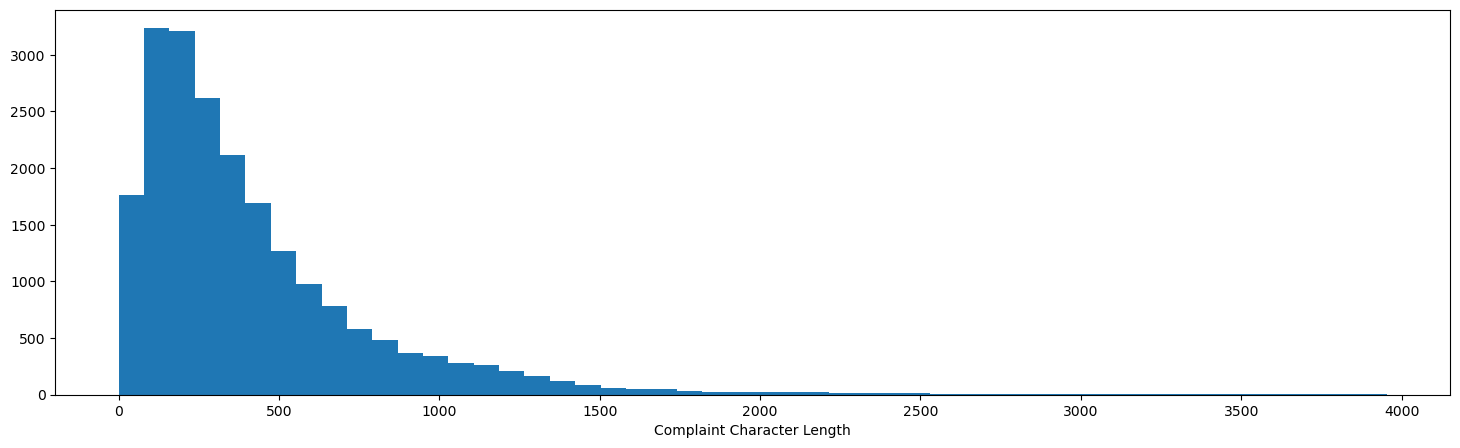

In [207]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(18,5))
plt.hist([l for l in df_clean.length if l < 4000], bins=50)
plt.xlabel("Complaint Character Length")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

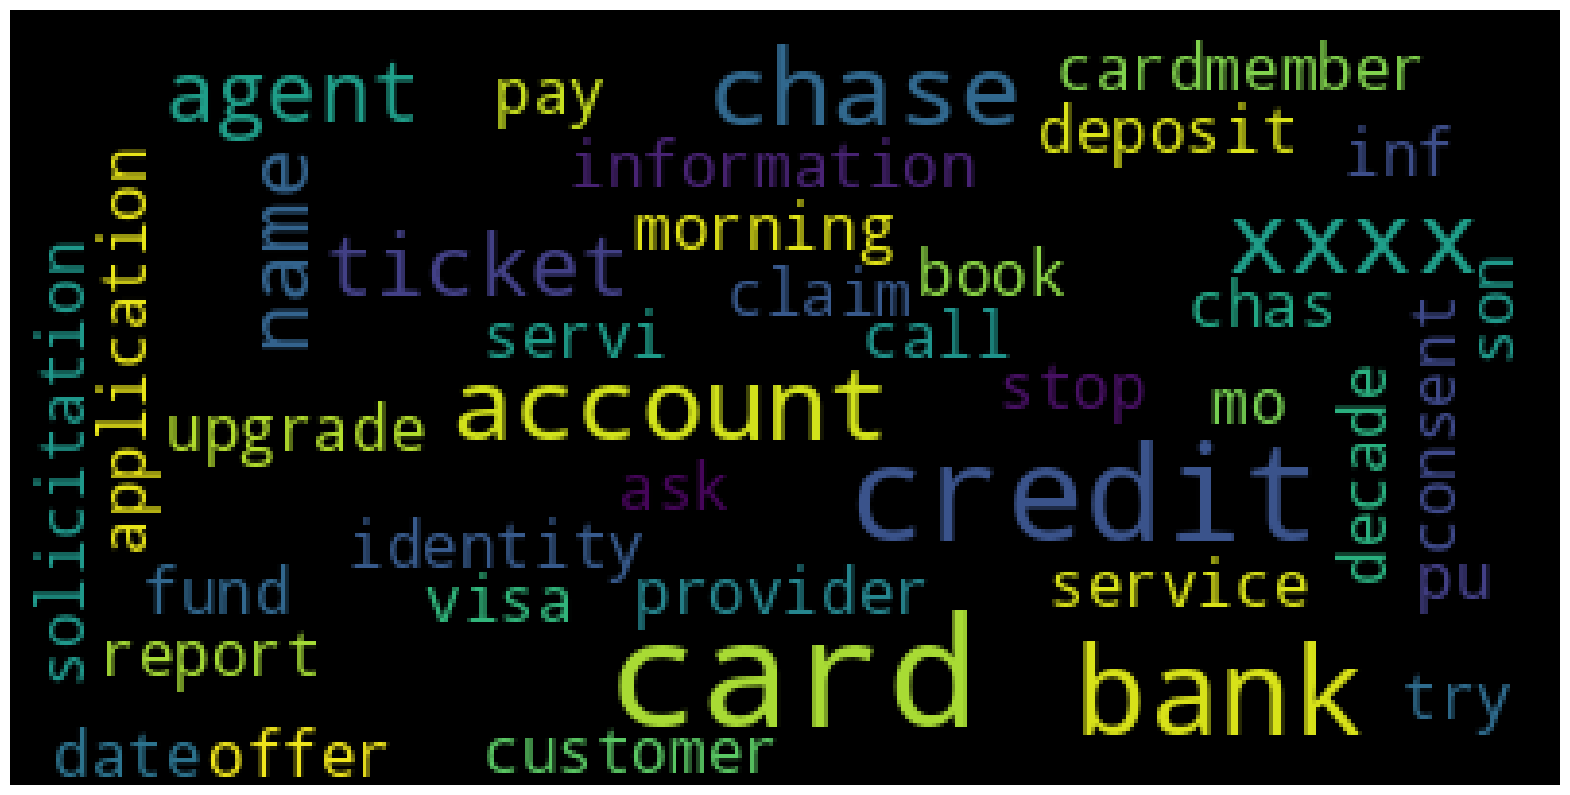

In [208]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

wordcloud = WordCloud(
    max_words=40,
    max_font_size=40
).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [209]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [210]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
complaints_list = df_clean['Complaint_clean'].tolist()

# Concatenate all complaints into a single string
all_complaints_text = " ".join(complaints_list)

# Tokenize the text into words
words = word_tokenize(all_complaints_text)

# Calculate the frequency distribution of unigrams
fdist = FreqDist(words)

# Get the top 30 most common unigrams
top_30_unigrams = fdist.most_common(30)

# Create a DataFrame to display the results
top_30_unigrams_df = pd.DataFrame(top_30_unigrams, columns=['Unigram', 'Frequency'])

# Display the top 30 unigrams
print(top_30_unigrams_df)

        Unigram  Frequency
0             i     104073
1         chase      49853
2       account      47475
3          xxxx      37734
4        credit      34131
5          card      29311
6          bank      28504
7       payment      21168
8          time      16045
9        charge      14814
10          day      12972
11        check      12867
12     xxxxxxxx      12439
13        money      11961
14         call      11114
15         loan      11002
16        state       9936
17       letter       9669
18  information       9653
19       report       9077
20          fee       8668
21  transaction       8650
22       number       8616
23        month       8463
24       amount       8396
25         year       8292
26     mortgage       8189
27     customer       8163
28      service       7851
29        claim       7825


In [211]:
#Print the top 10 words in the unigram frequency
top_30_unigrams_df.head(10)

,Unigram,Frequency
0,i,104073
1,chase,49853
2,account,47475
3,xxxx,37734
4,credit,34131
5,card,29311
6,bank,28504
7,payment,21168
8,time,16045
9,charge,14814


In [212]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
# Create bigrams from the list of words
bigrams = list(nltk.bigrams(words))

# Calculate the frequency distribution of bigrams
fdist = FreqDist(bigrams)

# Get the top 30 most common bigrams
top_30_bigrams = fdist.most_common(30)

# Create a DataFrame to display the results
top_30_bigrams_df = pd.DataFrame(top_30_bigrams, columns=['Bigram', 'Frequency'])

# Display the top 30 bigrams
print(top_30_bigrams_df)

                 Bigram  Frequency
0        (credit, card)      12759
1            (i, chase)       5764
2             (xxxx, i)       5156
3          (account, i)       4492
4         (xxxxxxxx, i)       4204
5      (credit, report)       3962
6          (xxxx, xxxx)       3764
7                (i, i)       3762
8         (chase, bank)       3286
9             (card, i)       3104
10  (customer, service)       3077
11         (i, account)       3054
12      (chase, credit)       3021
13          (i, credit)       2814
14            (i, bank)       2752
15            (i, xxxx)       2707
16     (check, account)       2671
17      (bank, account)       2607
18            (i, call)       2401
19     (account, chase)       2304
20     (chase, account)       2265
21           (chase, i)       2220
22         (i, payment)       2177
23         (payment, i)       1813
24   (account, account)       1796
25            (i, card)       1680
26        (phone, call)       1628
27          (i, char

In [213]:
#Print the top 10 words in the bigram frequency
top_30_bigrams_df.head(10)

,Bigram,Frequency
0,"(credit, card)",12759
1,"(i, chase)",5764
2,"(xxxx, i)",5156
3,"(account, i)",4492
4,"(xxxxxxxx, i)",4204
5,"(credit, report)",3962
6,"(xxxx, xxxx)",3764
7,"(i, i)",3762
8,"(chase, bank)",3286
9,"(card, i)",3104


In [214]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
# Create trigrams from the list of words
trigrams = list(nltk.ngrams(words, 3))

# Calculate the frequency distribution of trigrams
fdist = FreqDist(trigrams)

# Get the top 30 most common trigrams
top_30_trigrams = fdist.most_common(30)

# Create a DataFrame to display the results
top_30_trigrams_df = pd.DataFrame(top_30_trigrams, columns=['Trigram', 'Frequency'])

# Display the top 30 trigrams
print(top_30_trigrams_df)

                        Trigram  Frequency
0         (chase, credit, card)       2106
1             (i, credit, card)       1208
2             (credit, card, i)       1032
3       (credit, card, account)        981
4       (credit, card, company)        974
5         (credit, card, chase)        574
6               (xxxx, xxxx, i)        566
7              (i, call, chase)        486
8     (inquiry, credit, report)        475
9        (i, customer, service)        470
10         (xxxxxxxx, i, chase)        432
11             (i, chase, bank)        413
12       (credit, card, credit)        394
13       (charge, credit, card)        387
14  (credit, reporting, agency)        385
15           (i, chase, credit)        382
16           (xxxx, xxxx, xxxx)        364
17   (chase, customer, service)        363
18          (account, i, chase)        347
19      (account, credit, card)        338
20         (bank, credit, card)        335
21              (i, xxxx, xxxx)        333
22     (cre

In [215]:
#Print the top 10 words in the trigram frequency
top_30_trigrams_df.head(10)

,Trigram,Frequency
0,"(chase, credit, card)",2106
1,"(i, credit, card)",1208
2,"(credit, card, i)",1032
3,"(credit, card, account)",981
4,"(credit, card, company)",974
5,"(credit, card, chase)",574
6,"(xxxx, xxxx, i)",566
7,"(i, call, chase)",486
8,"(inquiry, credit, report)",475
9,"(i, customer, service)",470


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [216]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [217]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,length,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and i apprec...,morning name stop bank cardmember service ask ...,157,morning name stop bank cardmember service ask ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade my xxxx xxxx card in and be tell by ...,i card agent upgrade date agent information or...,107,i card agent upgrade date agent information or...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,card report application identity consent servi...,74,card report application identity consent servi...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket i come...,try book xxxx ticket i offer ticket card i inf...,441,try book ticket i offer ticket card i informa...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund bank account mo...,165,son deposit chase account fund bank account mo...
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,211,card customer decade solicitation credit card ...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i call chas my xxxx xxxx...,i call chas visa credit card provider claim pu...,687,i call chas visa credit card provider claim pu...
78310,I am not familiar with XXXX pay and did not un...,i be not familiar with xxxx pay and do not und...,pay risk provide consumer i bank app chase yea...,720,pay risk provide consumer i bank app chase yea...
78311,I have had flawless credit for 30 yrs. I've ha...,i have have flawless credit for yrs ive have c...,credit credit card chase freedom xxxx problem ...,497,credit credit card chase freedom problem bala...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [218]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english")

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [219]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean.Complaint_clean)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [220]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [221]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [222]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

7333

In [223]:
#Print the Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    words_in_topic = []
    for word_index in topic.argsort()[-15:]:
        words_in_topic.append(tfidf.get_feature_names_out()[word_index])
    print(f'topic {index}: {words_in_topic}')
    print('\n')

topic 0: ['transfer', 'claim', 'checking', 'business', 'transaction', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']


topic 1: ['balance', 'letter', 'application', 'debt', 'information', 'bureau', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


topic 2: ['mortgage', 'year', 'account', 'credit', 'chase', 'date', 'auto', 'pay', 'time', 'day', 'statement', 'fee', 'month', 'balance', 'payment']


topic 3: ['company', 'statement', 'refund', 'time', 'service', 'claim', 'fraud', 'purchase', 'merchant', 'dispute', 'fee', 'transaction', 'chase', 'card', 'charge']


topic 4: ['sale', 'foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'chase', 'modification', 'home', 'mortgage', 'loan']




In [224]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([0, 1, 1, ..., 3, 2, 2])

In [225]:
df_clean.shape

(21072, 5)

In [226]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = df_clean['Topic'] = topic_results.argmax(axis = 1) #write your code to assign topics to each rows.

In [227]:
df_clean.shape

(21072, 6)

In [228]:
df_clean.head()

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and i apprec...,morning name stop bank cardmember service ask ...,157,morning name stop bank cardmember service ask ...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade my xxxx xxxx card in and be tell by ...,i card agent upgrade date agent information or...,107,i card agent upgrade date agent information or...,1
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,card report application identity consent servi...,74,card report application identity consent servi...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket i come...,try book xxxx ticket i offer ticket card i inf...,441,try book ticket i offer ticket card i informa...,1
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund bank account mo...,165,son deposit chase account fund bank account mo...,0


In [229]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and i apprec...,morning name stop bank cardmember service ask ...,157,morning name stop bank cardmember service ask ...,0
28024,I filed a claim with Chase/XXXX in XXXX when a...,i file a claim with chasexxxx in xxxx when a f...,i claim chasexxxx xxxx fraudster somehow accou...,235,i claim chase fraudster somehow account infor...,0
28003,"I paid for a course offered on XXXX to a guy, ...",i pay for a course offer on xxxx to a guy he a...,pay course offer xxxx guy dollar advance cours...,96,pay course offer guy dollar advance course pa...,0
28002,JPMorgan Chase Bank N.A as successor by merger...,jpmorgan chase bank na as successor by merger ...,bank na successor merger bank retaliate file c...,700,bank na successor merger bank retaliate file c...,0
26985,On XX/XX/18 at XXXX XXXX I deposited {$800.00}...,on at xxxx xxxx i deposit cash into a chase at...,deposit cash atm cash account snag deposit ple...,139,deposit cash atm cash account snag deposit ple...,0
...,...,...,...,...,...,...
61993,I paid off my car loan with Chase Bank and it ...,i pay off my car loan with chase bank and it r...,car loan bank account credit score,34,car loan bank account credit score,4
61992,XXXX I contacted Chase Slate card services twi...,xxxx i contact chase slate card service twice ...,xxxx i card service pay credit card i amount b...,365,i card service pay credit card i amount balan...,4
61991,I filed for a loan modification with Chase som...,i file for a loan modification with chase some...,i file loan modification chase time chase docu...,158,i file loan modification chase time chase docu...,4
62021,My father has a home equity line of credit ( m...,my father have a home equity line of credit mo...,father home equity line credit mortgage bank y...,250,father home equity line credit mortgage bank y...,4


In [230]:
df_clean.shape

(21072, 6)

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [231]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [232]:
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and i apprec...,morning name stop bank cardmember service ask ...,157,morning name stop bank cardmember service ask ...,Bank Account services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade my xxxx xxxx card in and be tell by ...,i card agent upgrade date agent information or...,107,i card agent upgrade date agent information or...,Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,card report application identity consent servi...,74,card report application identity consent servi...,Credit card or prepaid card
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket i come...,try book xxxx ticket i offer ticket card i inf...,441,try book ticket i offer ticket card i informa...,Credit card or prepaid card
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund bank account mo...,165,son deposit chase account fund bank account mo...,Bank Account services
...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,211,card customer decade solicitation credit card ...,Credit card or prepaid card
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i call chas my xxxx xxxx...,i call chas visa credit card provider claim pu...,687,i call chas visa credit card provider claim pu...,Theft/Dispute Reporting
78310,I am not familiar with XXXX pay and did not un...,i be not familiar with xxxx pay and do not und...,pay risk provide consumer i bank app chase yea...,720,pay risk provide consumer i bank app chase yea...,Theft/Dispute Reporting
78311,I have had flawless credit for 30 yrs. I've ha...,i have have flawless credit for yrs ive have c...,credit credit card chase freedom xxxx problem ...,497,credit credit card chase freedom problem bala...,Others


In [233]:
df_clean.shape

(21072, 6)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [234]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [235]:
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and i apprec...,morning name stop bank cardmember service ask ...,157,morning name stop bank cardmember service ask ...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade my xxxx xxxx card in and be tell by ...,i card agent upgrade date agent information or...,107,i card agent upgrade date agent information or...,1
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,card report application identity consent servi...,74,card report application identity consent servi...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket i come...,try book xxxx ticket i offer ticket card i inf...,441,try book ticket i offer ticket card i informa...,1
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund bank account mo...,165,son deposit chase account fund bank account mo...,0
...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,211,card customer decade solicitation credit card ...,1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i call chas my xxxx xxxx...,i call chas visa credit card provider claim pu...,687,i call chas visa credit card provider claim pu...,3
78310,I am not familiar with XXXX pay and did not un...,i be not familiar with xxxx pay and do not und...,pay risk provide consumer i bank app chase yea...,720,pay risk provide consumer i bank app chase yea...,3
78311,I have had flawless credit for 30 yrs. I've ha...,i have have flawless credit for yrs ive have c...,credit credit card chase freedom xxxx problem ...,497,credit credit card chase freedom problem bala...,2


In [236]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["complaint_what_happened","Topic"]]

In [237]:
training_data

,complaint_what_happened,Topic
1,Good morning my name is XXXX XXXX and I apprec...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
10,Chase Card was reported on XX/XX/2019. However...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",1
14,my grand son give me check for {$1600.00} i de...,0
...,...,...
78303,After being a Chase Card customer for well ove...,1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",3
78310,I am not familiar with XXXX pay and did not un...,3
78311,I have had flawless credit for 30 yrs. I've ha...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [238]:
#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaint_what_happened)

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [239]:
from sklearn.model_selection import train_test_split

# Performing Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [240]:
# Write your code here to build any 3 models and evaluate them using the required metrics





In [241]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Run the Logistic Regression model
model_name = 'LOGISTIC REGRESSION'
clf_lr = LogisticRegression(solver='liblinear')
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

In [242]:
# Calculate F1 Score using weighted average method
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
f1_lr

0.9190060131373227

In [243]:
# Run Logistic Regression on tuned hyperparameters
clf_lr_tuned = LogisticRegression(C=1, penalty='l1',solver='saga')
%time 
clf_lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = clf_lr_tuned.predict(X_test)

CPU times: user 16 µs, sys: 1 µs, total: 17 µs
Wall time: 20.7 µs


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [244]:
# Calculate F1 Score of tuned model using weighted average method
f1_lr_tuned = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr_tuned

0.9377123491685615

In [245]:
from sklearn.tree import DecisionTreeClassifier

# Run Decision Tree on default hyperparameters
model_name = 'DECISION TREE'
clf_dt = DecisionTreeClassifier()
%time 
clf_dt.fit(X_train, y_train)
y_pred_dt = clf_dt.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


In [246]:
# Calculate F1 Score using weighted average method
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
f1_dt

0.7814115027492646

In [249]:
# Run Decision Tree on tuned hyperparameters
clf_dt_tuned = DecisionTreeClassifier(criterion='gini', max_depth=30, min_samples_leaf=15, max_features=None)
%time 
clf_dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = clf_dt_tuned.predict(X_test)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 50.1 µs


In [250]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt_tuned = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt_tuned

0.7927391504578102

In [247]:
from sklearn.ensemble import RandomForestClassifier

# Run the Random Forest model on default hyperparameters
model_name = 'RANDOM FOREST'
clf_rf = RandomForestClassifier()
%time 
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs


In [248]:
# Calculate F1 Score using weighted average method
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
f1_rf

0.8106589964014258

In [251]:
# Run Random Forest on tuned hyperparameters
clf_rf_tuned = RandomForestClassifier(n_estimators=100, min_samples_split=5, min_samples_leaf=5, max_features=None, max_depth=30, criterion='gini')
%time 
clf_rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = clf_rf_tuned.predict(X_test)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 13.6 µs


In [252]:
# Calculate F1 Score of tuned model using weighted average method
f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned, average="weighted")
f1_rf_tuned

0.8434745002081391